Machine learning model for predicting fuel consumption.

Hyperparameter tuning and training of various linear and tree-based algorithms.

Comparison of optimally tuned models.

Perform model tuning and validation on splits of 'train' set (years 2019, 2020).

Perform final model testing on 'test' set (year 2021).

Input(s): 
- df_ml_[variant]_train.csv
- df_ml_[variant]_test.csv

Output(s): 
- Git Untracked Data:
    - Model dataframes with fitted estimators after certain steps
        - _mdl_df_base.pkl
        - _mdl_df_best.pkl
        - _mdl_df_kf.pkl
        - _mdl_df_compare.pkl
- Git Tracked Data:
    - parameters: _params.csv
    - stats comparisons for residual and fuel consumption: e.g. _best_fc.csv
    - feature importance rankings: _FI.csv    

## Preamble

In [1]:
import os
import string
import sys
# from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    # RandomizedSearchCV,
    # cross_val_score,
    # cross_validate,
    # train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error #, PredictionErrorDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, LeavePOut, KFold
import seaborn as sns
import pickle # for saving models
from sklearn.inspection import permutation_importance # for permutation feature importance
import time #for timing


## Global Settings

In [2]:
tol_type = 'abs' # 'rel' or 'abs' tolerance type for subsetting 'valid' data based on distance discrepancy
outlier_threshold = 3 #np.Inf # number of standard deviations from the mean to consider a point an outlier
feature_set = 'm5dd' # feature set to use (defined herein)
validation_stats = ['r2', 'corr', 'mse', 'mae', 'mape']
cv_folds = 5
cv_scoring = 'r2'
max_cores = 6
eval_folds = 100 # number of folds for evaluation

sns.set_theme(
    context='paper',
    palette='bright', # deep, dark, bright, colorblind
    font_scale=1.4
    ) 
sns.set_style('whitegrid',
    {'axes.grid': False})
plt.rcParams["font.family"] = "Bitstream Vera Sans"
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15

datapath = 'Machine Learning/data/'
readdatapath = 'src/tracked_data/'
trackeddatapath = 'Machine Learning/tracked_data/'
plotpath = 'Machine Learning/plots/'
fileprefix = 'ML_FC_F' + feature_set + '_' #+ '_nofilter_' 
model_df_filename = 'mdl_df'

start_time = time.time()

param_vars = [
    'tol_type',
    'outlier_threshold',
    'feature_set',
    'cv_folds',
    'cv_scoring',
    'eval_folds',
    'datapath',
    'trackeddatapath',
    'plotpath',
    'fileprefix',
    'model_df_filename']

# if os.path.exists(trackeddatapath + fileprefix + 'params.csv'):
#     sys.exit('File already exists. Delete params csv file to overwrite all related data.')


pd.DataFrame(
    [(i, globals()[i]) for i in param_vars],
    columns = ['parameter', 'value']
    ).to_csv(
        trackeddatapath + fileprefix + 'params.csv',
        index = False)

print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")

Started at: 2024-03-27 22:44:38


### Functions

In [3]:
def col_search(searchkey):
    """
    Search for column names containing a given string and print summary statistics. (case insensitive)
    """
    colname_matches = [col for col in df_ml.columns if searchkey.lower() in col.lower()]
    if len(colname_matches) > 0:
        print(colname_matches)
        df_ml[colname_matches].describe()
        for col in colname_matches:
            if df_ml[col].nunique() <= 10:
                print(col)
                print(df_ml[colname_matches].value_counts())
    else:
        print('No matches found')

def plot_45deg_line(x, y):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = max(x.max(), y.max()) + 0.1
    lower = min(x.min(), y.min()) - 0.1
    x0 = np.linspace(lower, upper, 100)
    plt.plot(x0, x0, color='black', label='x=y')

def two_way_plot(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend_title=None, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    plt.figure(figsize=(5, 5), dpi=300)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha)
    if regline:
        sns.regplot(data=data, x=x, y=y, scatter=False, line_kws={'linestyle':'dashed'}, label='regression line', color='red')
    if data is None:
        plot_45deg_line(x, y)
    else:
        plot_45deg_line(data[x], data[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=legend_title)
    if savepath:
        plt.savefig(savepath)
    plt.show()

def plot_45deg_line_new(x, y, ax):
    """
    Create a two-way plot with a 45-degree line.
    """
    upper = max(x.max(), y.max()) + 0.1
    lower = min(x.min(), y.min()) - 0.1
    x0 = np.linspace(lower, upper, 100)
    ax.plot(x0, x0, color='black', label='x=y')

def two_way_plot_new(x, y, data=None, hue=None, alpha=0.5, title=None, xlabel=None, ylabel=None, legend_title=None, regline=False, savepath=None):
    """
    Create a two-way plot with a regression line.
    """
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, alpha=alpha, ax=ax)
    if regline:
        sns.regplot(data=data, x=x, y=y, scatter=False, line_kws={'linestyle':'dashed'}, label='regression line', color='red', ax=ax)
    if data is None:
        plot_45deg_line_new(x, y, ax=ax)
    else:
        plot_45deg_line_new(data[x], data[y], ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title)
    if savepath:
        plt.savefig(savepath)
    plt.show()
    return ax

# def make_estimator_default(scaling, mdlclass):
#     if scaling:
#         estimator = make_pipeline(preprocessor_scaling, mdlclass)
#     elif ~scaling:
#         estimator = make_pipeline(preprocessor_noscaling, mdlclass)
#     return estimator

def make_estimator(scaling, classname, params=None):
    if params is None:
        if classname == 'LinearRegression':
            estimator = make_pipeline(preprocessor_noscaling_drop, globals()[classname]())
        elif scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname]())
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname]())
    else:
        if scaling:
            estimator = make_pipeline(preprocessor_scaling, globals()[classname](**params))
        elif ~scaling:
            estimator = make_pipeline(preprocessor_noscaling, globals()[classname](**params))
    return estimator
    
def MAE(y_true, y_pred):
    """
    Calculate mean absolute error.
    """
    return np.mean(np.abs(y_true - y_pred))
                   
def MAPE(y_true, y_pred):
    """
    Calculate mean absolute percentage error.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true))

def corr2(x, y):
    """
    Calculate the correlation coefficient.
    """
    return np.corrcoef(x, y)[0, 1]

def calculate_stats(y_true, y_pred, data=None, stats=None):
    """
    Create a dictionary of statistics for a model.
    """
    if data is not None:
        y_true = data[y_true]
        y_pred = data[y_pred]

    stats_dict = {}
    names_dict = {}
    defined_stats = {
        'r2': (r2_score, 'R²'),
        'corr': (corr2, 'Correlation'),
        'mse': (mean_squared_error, 'MSE'),
        'mae': (MAE, 'MAE'),
        'mape': (MAPE, 'MAPE')
    }
    stats = [stat for stat in stats if stat in defined_stats]
    for stat in stats:
        stats_dict[stat] = defined_stats[stat][0](y_true, y_pred)
        names_dict[stat] = defined_stats[stat][1]
    return {'stats' : stats_dict, 'names' : names_dict}    

def create_legend_title(stats_dict):
    """
    Create a legend title for a plot based on a dictionary of statistics.
    """
    legend_title = ''
    for key in stats_dict['stats']:
        legend_title += f"{stats_dict['names'][key]}: {round(stats_dict['stats'][key],3)}\n"
    return legend_title

def format_cv_results(grid_search):
    """
    Format the results of a grid search as a pandas DataFrame.
    """
    cv_results = pd.DataFrame(grid_search.cv_results_)[['param_gradientboostingregressor__learning_rate', 'param_gradientboostingregressor__max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
    # shorten column names
    cv_results.columns = cv_results.columns.str.removeprefix('param_gradientboostingregressor__')
    cv_results.columns = cv_results.columns.str.replace('_score', '_' + cv_scoring)
    print(f"Model: { grid_search.estimator.named_steps['gradientboostingregressor'].__class__.__name__ }")
    return cv_results

# def model_comparison_table(stats_to_compare, params=None):
#     """
#     Create a pandas DataFrame of statistics for multiple models.
#     Args:
#         stats_to_compare: dictionary of tuples of statistics dictionaries and models
#     Returns:
#         pandas DataFrame
#     """
#     for key, value in stats_to_compare.items():
#         value[0]['stats']['model'] = key
#         if params is not None:
#             for param in params:
#                 try:
#                     value[0]['stats'][param] = value[1][-1].get_params()[param]
#                 except:
#                     value[0]['stats'][param] = np.nan

#     compare_df = pd.DataFrame([value[0]['stats'] for key, value in stats_to_compare.items()]).set_index('model')
#     return compare_df

def tribble(columns, *data):
    return pd.DataFrame(
        data=list(zip(*[iter(data)]*len(columns))),
        columns=columns
    )

def model_stats_comparison_table(stats_col, params_col, estimator_col, mdl_df):
    """
    Create a pandas DataFrame of statistics for multiple models.
    Args: 
        stats_col: name of column containing statistics
        estimator_col: name of column containing fitted estimators
    Returns:
        pandas DataFrame
    """

    compare_df = mdl_df.loc[:, [stats_col, estimator_col, params_col, 'class_name']]
    # unpack stats column
    compare_df[stats_col] = compare_df[stats_col].apply(lambda x: x['stats'])

    # create column for each statistic
    for key in compare_df[stats_col].iloc[0].keys():
        compare_df[key] = compare_df[stats_col].apply(lambda x: x[key])

    # # add model parameters from fitted estimator
    # compare_df['params'] = compare_df.apply(lambda row: row[estimator_col].named_steps[row['class_name'].lower()].get_params(), axis=1)
    # # filter the parameters to the ones in params_col
    # compare_df['params'] = compare_df.apply(lambda row: filter_params(row, params_col, 'params'), axis=1)
    compare_df['params'] = compare_df.apply(lambda row: extract_filter_params(row, estimator_col, params_col), axis=1)

    return compare_df.drop([stats_col, estimator_col, params_col], axis=1)

def extract_filter_params(row, estimator_col, params_col_mask): 
    """ 
    Extract and filter the parameters to the ones in params_col and drop parameter name prefix.
    Args:
        row: pandas DataFrame row
        estimator_col: name of column containing fitted estimators
        params_col_mask: name of column containing parameters to keep (should be without model name prefix)
    """
    params = row[estimator_col].named_steps[row['class_name'].lower()].get_params()
    if row[params_col_mask] is None:
        return None
    else:
        return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in params.items() if k in row[params_col_mask].keys()}

# def filter_params(row, params_col, params_col_mask): 
#     """ 
#     Filter the parameters to the ones in params_col and drop parameter name prefix.
#     """
#     if row[params_col_mask] is None:
#         return None
#     else:
#         return {k.replace(row['class_name'].lower() + '__', ''): v for k, v in row[params_col].items() if k in row[params_col_mask].keys()}
    
def loo_evaluation(estimator):
    """
    Performs leave-one-out evaluation and returns the predicted residuals.
    """
    loo_prediction = np.zeros(len(y))

    for train_index, val_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        estimator.fit(X_train, y_train)
        loo_prediction[val_index] = estimator.predict(X_val)
    
    return loo_prediction

def kfold_evaluation(estimator, name):
    """
    Performs k-fold evaluation and returns the predicted residuals.
    """
    print(f"Starting evaluating {name} at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}")
    kf_prediction = np.zeros(len(y))

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        estimator.fit(X_train, y_train)
        kf_prediction[val_index] = estimator.predict(X_val)
    
    return kf_prediction

def FI_plot(FI, model_name):
    FI_df = pd.DataFrame(FI.importances, index = features).assign(mean=lambda df: df.mean(axis=1)).sort_values('mean')
    plt.figure(figsize=(5, 5), dpi=300)
    plt.boxplot(
        FI_df.drop(columns='mean').T,
        vert=False,
        labels=np.array(FI_df.index),
    )
    plt.title('Permutation Importances: ' + model_name)
    plt.savefig(plotpath + fileprefix + 'FI_perm_' + model_name + '.png')
    plt.show()

## Data Validation and Preprocessing

### Load

In [4]:
df_ml = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_train.csv", low_memory=False)

# for nicer colors when plotting
df_ml = df_ml.sort_values('year')
df_ml['year_str'] = df_ml['year'].astype(str) 

##### Column name search


In [5]:
col_search('MRV')

['MRV.EU.distance', 'MRV.method.a', 'MRV.method.b', 'MRV.method.c', 'MRV.method.d', 'MRV.verifier.country', 'MRV.verifier.name', 'MRV.ship.type']
MRV.method.a
Series([], Name: count, dtype: int64)
MRV.method.b
Series([], Name: count, dtype: int64)
MRV.method.c
Series([], Name: count, dtype: int64)
MRV.method.d
Series([], Name: count, dtype: int64)
MRV.verifier.country
Series([], Name: count, dtype: int64)
MRV.ship.type
Series([], Name: count, dtype: int64)


In [6]:

df_ml.loc[:, df_ml.columns.str.contains('Type', case=False)].describe(include='all')

,Main.Engine.Fuel.Type,Type,Old.Type,Owner.Main.Vessel.Type,Alternative.Fuel.Types,Fleet.Type,Self.Unloader.Type,BWMS.Technology.Type,Hull.Type,Alternative.Fuel.Type.Ready,MRV.ship.type
count,1281,1281,1,1272,0.0,1281,4,948,30,0.0,1281
unique,4,5,1,16,NaN,1,1,11,2,NaN,4
top,VLS IFO,Bulk Carrier,Products,Bulker,NaN,Bulkers,Conveyor,FILTRATION - ELECTROLYSIS (ELECTRO-CHLORINATIO...,D/Hull,NaN,Bulk carrier
freq,1134,1103,1,319,NaN,1281,4,392,28,NaN,1165
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_ml['Type'].value_counts(dropna=False)

Type
Bulk Carrier          1103
Open Hatch Carrier     172
Chip Carrier             4
Ore Carrier              1
Cement Carrier           1
Name: count, dtype: int64

### Stats


In [8]:
raw_mean = df_ml['residual'].mean()
raw_std = df_ml['residual'].std()
print(f'Raw Data: \n observations: {len(df_ml)} \n target mean: {raw_mean} \n target sd: {raw_std}')

stats_raw = calculate_stats('log_report_fc', 'log_cal_fc', df_ml, validation_stats)

Raw Data: 
 observations: 1281 
 target mean: -0.05601808721490245 
 target sd: 0.6720487677515353


#### Scatter plot of reported vs calculated fuel consumption

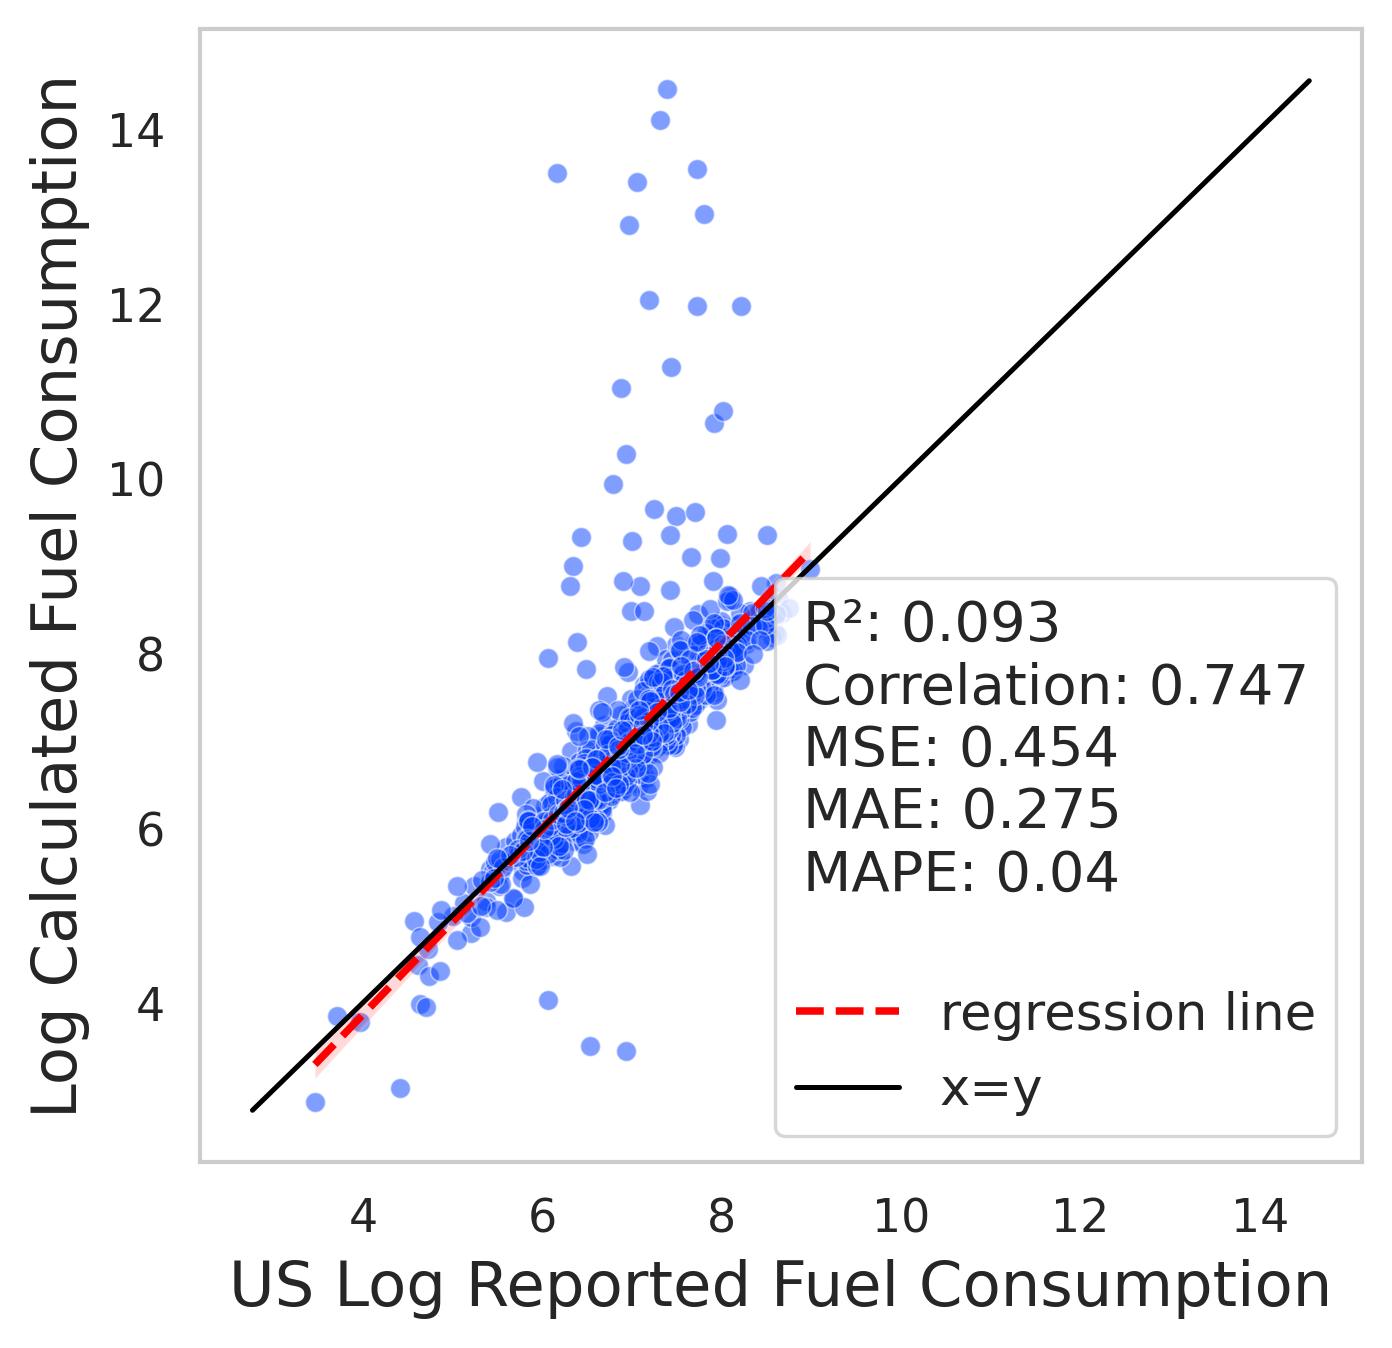

In [12]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml,
     # title='Raw Data',
     xlabel='US Log Reported Fuel Consumption',
     ylabel='Log Calculated Fuel Consumption',
     legend_title=create_legend_title(stats_raw),
     regline=True,
     savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

#### Scatter plot of reported vs calculated fuel consumption by year using two_way_plot

In [ ]:
two_way_plot(
    'log_report_fc',
    'log_cal_fc',
    df_ml,
    hue='year_str',
    alpha=0.3,
    title='Raw Data',
    xlabel='log Reported Fuel Consumption',
    ylabel='log Calculated Fuel Consumption',
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_fcbyyear_raw.png')

### Outliers

#### Explore outliers

In [ ]:
df_ml['outlier'] = ~df_ml['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')
# df_ml.loc[df_ml['outlier'],:]


In [ ]:
df_ml['outlier'].value_counts()

In [ ]:
# compare means of outliers and non
df_ml.loc[:, ['outlier'] + df_ml.select_dtypes(include=[np.number]).columns.tolist()].groupby('outlier').agg('mean')

In [ ]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml,
     hue='outlier',
     title='Raw Data',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title='Outlier',
     regline=False,
     savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

In [ ]:
# Compare distributions for a given variable
sns.histplot(data=df_ml, x='Dwt', hue='outlier', stat='proportion', common_norm=False)

In [ ]:
# check largest correlates
(
    df_ml
    .corr(numeric_only=True)
    .loc[:, ['outlier']]
    .assign(abs_corr=lambda x: abs(x))
    .sort_values('abs_corr', ascending=False)
    .head(30)
    )


#### Train algorithm to identify outliers?
(in order to find cause)

In [ ]:
# from sklearn.linear_model import Lasso

# # Select the numeric variables
# numeric_vars = df_ml.select_dtypes(include=[np.number]).columns.tolist()
# # remove any features that have all values missing
# numeric_vars = [var for var in numeric_vars if df_ml[var].notnull().sum() > 0]
# numeric_vars = numeric_vars[1:25]

# # Split the data into input features (X) and target variable (y)
# X = df_ml[numeric_vars]
# y = df_ml['outlier'].astype(int)

# # create a pipeline to impute missing values and scale the data, then do lasso
# preprocessor = make_column_transformer(
#     (SimpleImputer(strategy='median'), numeric_vars),
#     remainder='passthrough'
# )

# lasso_coefs = pd.DataFrame(pipeline.named_steps['lasso'].coef_, index=numeric_vars).assign(abs=lambda x: abs(x), col='0').sort_values('abs', ascending=False)
# lasso_coefs

In [ ]:
# from sklearn.feature_selection import SelectKBest, chi2

# # Select the top k features based on chi-square test
# k = 5  # Number of top features to select
# X = df_ml.drop(['outlier'], axis=1)  # Input features
# y = df_ml['outlier']  # Target variable

# # create list of non-numeric features
# non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
# # create column transformer to one-hot encode non-numeric features and impute missing values with median

# preprocessor = make_column_transformer(
#     (OneHotEncoder(), non_numeric),
#     remainder='passthrough'
# )

# pipeline = make_pipeline(
#     preprocessor,
#     SimpleImputer(strategy='median'),
#     SelectKBest(score_func=chi2, k=k)
# )

# X_selected = pipeline.fit(X, y)

# # Get the selected feature names
# selected_feature_names = X.columns[selector.get_support()]

# # Print the selected feature names
# print("Selected Features:")
# for feature in selected_feature_names:
#     print(feature)


### Filter out outliers 

In [ ]:
df_ml = df_ml.loc[~df_ml['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n target mean: {df_ml.residual.mean()} \n target sd: {df_ml.residual.std()}')


#### Scatter plot of reported vs calculated fuel consumption


In [ ]:
stats_filtered = calculate_stats('log_report_fc', 'log_cal_fc', df_ml, validation_stats)
two_way_plot(
    'log_report_fc',
    'log_cal_fc',
    df_ml,
    title='Filtered Data',
    xlabel='log Reported Fuel Consumption',
    ylabel='log Calculated Fuel Consumption',
    legend_title=create_legend_title(stats_filtered),
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_fc_filtered.png')

#### Scatter plot of reported vs calculated fuel consumption by year

In [ ]:
two_way_plot(
    'log_report_fc',
    'log_cal_fc',
    df_ml,
    hue='year_str',
    alpha=0.3,
    title='Filtered Data',
    xlabel='log Reported Fuel Consumption',
    ylabel='log Calculated Fuel Consumption',
    regline=True,
    savepath=plotpath + fileprefix + 'twoway_fcbyyear_filtered.png')

##### Histogram of residuals

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml, x='residual', kde=False)
plt.title('Filtered Data')
plt.xlabel('Residual')
plt.axvline(df_ml['residual'].mean(), color='black', linestyle='solid', linewidth=1, label='mean')
plt.axvline(df_ml['residual'].median(), color='black', linestyle='dashed', linewidth=1, label='median')
plt.legend()
plt.savefig(plotpath + fileprefix + 'hist_residual_filtered.png')
plt.show()


##### Histogram of residuals by year

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml, x='residual', hue='year_str', alpha=0.5, kde=False)
hue_values = df_ml['year'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for year, color in color_map.items():
    plt.axvline(df_ml[df_ml['year'] == year]['residual'].mean(), color=color)
plt.title('Filtered Data')
plt.xlabel('Residual')
plt.savefig(plotpath + fileprefix + 'hist_residualbyyear_filtered_.png')
plt.show()

## Feature Selection


### Manually Selected Features


In [ ]:
features_dict = {
    'm1' : [
        'Draught..m.',   # Ship draught specification
        'HP.Total.Propulsion', # Total ship propulsion power
        'Service.Speed..knots.', # Nominal ship speed
        'LOA..m.', # Length of ship
        'Operational.Speed..knots.', # Average observed travel speed (from WFR)
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        'Ballast.Cap..cu.m.', # Ballast tank capacity
        'Bale.Capacity..cu.m.', # Bale capacity
        'LBP..m.', # Length between perpendiculars
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', # snapshot in time, value from WFR
        'EU.distance', # Annual distance travelled (EU trips) reported in MRV
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        'ME_W_ref_first', # Main engine power from WFR
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'age', # Yearly age of ship (observed year - built year)
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'Size.Category' # Ship size category from WFR
        ],
    'm1a' : [ # remove EU.distance because MRV reported variable
        'Draught..m.',   # Ship draught specification
        'HP.Total.Propulsion', # Total ship propulsion power
        'Service.Speed..knots.', # Nominal ship speed
        'LOA..m.', # Length of ship
        'Operational.Speed..knots.', # Average observed travel speed (from WFR)
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        'Ballast.Cap..cu.m.', # Ballast tank capacity
        'Bale.Capacity..cu.m.', # Bale capacity
        'LBP..m.', # Length between perpendiculars
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', # snapshot in time, value from WFR
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        'ME_W_ref_first', # Main engine power from WFR
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'age', # Yearly age of ship (observed year - built year)
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'Size.Category' # Ship size category from WFR
        ],
    'm1b' : [ # remove EU.distance because MRV reported variable, remove West coast deployment, bale capacity, ballast capacity (odd, missings), add dwt, longest_jump, and port_frac
        'Draught..m.',   # Ship draught specification
        'HP.Total.Propulsion', # Total ship propulsion power
        'Service.Speed..knots.', # Nominal ship speed
        'LOA..m.', # Length of ship
        'Operational.Speed..knots.', # Average observed travel speed (from WFR)
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        'LBP..m.', # Length between perpendiculars
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        'ME_W_ref_first', # Main engine power from WFR
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'age', # Yearly age of ship (observed year - built year)
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'Size.Category', # Ship size category from WFR
        'longest_jump',
        'port_frac',
        'Dwt'
        ],
    'm2' : [
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        ],
    'm2a' : [ # add cal_fc
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data

        'cal_fc'
        ],
    'm2b' : [ # remove everything used to directly calculate cal_fc
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        
        ],
    'm2c' : [ # exhaustive components of admiralty formula
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        ],
    'm3' : [
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'distance_sum', # Calculated distance travelled (EU trips) from our AIS data
        'work_sum', # Calculated work done (EU trips) from our AIS data
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations
        'MRV.method.a',
        'MRV.method.b',
        'MRV.method.c',
        'MRV.method.d',
        'MRV.verifier.country',
        'MRV.verifier.name',
        
        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        ],
    'm4a' : [ # only cal_fc and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'cal_fc'
        ],
    'm4ad' : [ # only cal_fc and no distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
    'm4b' : [ # only work_sum and no distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'work_sum'
        ],
'm4bd' : [ # only work_sum and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
'm4cd' : [ # components and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        # 't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        # 't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        # 'v_over_v_ref_without_n_sum' # sum[(v/v_ref)], annual sum of instantaneous values from AIS data

        ## Distance
        'distance_sum'
        ],
    'm4dd' : [ # kitchen sink
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
    'm4ed' : [ # only components not direclty in cal_fc, cal_fc,  and distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'cal_fc',
        
        ## Distance
        'distance_sum'
        ],
    'm4fd' : [ # only distance
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations
        
        ## Distance
        'distance_sum'
        ],
    'm4f' : [ # only static
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        'HP.Total.Propulsion', # Total ship propulsion power
        # 'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations
        ],
    'm5dd' : [ # kitchen sink, swap ME_W for Total.Propulsion
        # Speed
        'Speed..knots.', # Representative speed value (vague definition, see Clarkson's message)
        
        # Engine
        # 'HP.Total.Propulsion', # Total ship propulsion power
        'ME_W_ref_first', # Main engine power from WFR
        
        # Dimensions
        'Draught..m.',   # Ship draught specification
        'LBP..m.', # Length between perpendiculars
        'LOA..m.', # Length of ship
        'Beam.Mld..m.', # Width of ship
        'TPC', # tonnage per centimeter (load required to increase draught)
        # Size/capacity
        'Size.Category', # Ship size category from WFR
        'Dwt',
        'NT', # Net tonnage: dimensionless index calculated from the total moulded volume of the ship's *cargo* space
        # 'Ballast.Cap..cu.m.', # Ballast tank capacity
        # 'Bale.Capacity..cu.m.', # Bale capacity

        # Other
        'age', # Yearly age of ship (observed year - built year)

        # from AIS
        'trip_nunique', # Number of unique EU trips detected from our AIS data
        'port_frac', # fraction (misnamed!) of EU-related observations at port
        
        ## Data quality
        'missing_frac_sea', # annual fraction of observations classified as 'sea' phase (i.e. steaming) that are interpolated (rather than observed)
        'longest_jump', # longest distance between two observations        

        ## Admiralty formula components
        'W_component_first', # Fixed, ship-specific component of power, calculated from WFR data
        't_m_times_v_n_sum', # sum[draught^m * speed^n], annual sum of instantaneous values from AIS data
        't_over_t_ref_with_m_sum', # sum[(t/t_ref)^m], annual sum of instantaneous values from AIS data
        't_over_t_ref_without_m_sum', # sum[(t/t_ref)], annual sum of instantaneous values from AIS data
        'v_over_v_ref_with_n_sum', # sum[(v/v_ref)^n], annual sum of instantaneous values from AIS data
        'v_over_v_ref_without_n_sum', # sum[(v/v_ref)], annual sum of instantaneous values from AIS data
        'cal_fc',

        ## Distance
        'distance_sum'
        ],
}

ordinal_cols_dict = {
    'm1' : ['Size.Category'],
    'm1a' : ['Size.Category'],
    'm1b' : ['Size.Category'],
    'm2' : ['Size.Category'],
    'm2a' : ['Size.Category'],
    'm2b' : ['Size.Category'],
    'm2c' : ['Size.Category'],
    'm3' : ['Size.Category'],
    'm4a' : ['Size.Category'],
    'm4ad' : ['Size.Category'],
    'm4b' : ['Size.Category'],
    'm4bd' : ['Size.Category'],
    'm4cd' : ['Size.Category'],
    'm4dd' : ['Size.Category'],
    'm4ed' : ['Size.Category'],
    'm4fd' : ['Size.Category'],
    'm4f' : ['Size.Category'],
    'm5dd' : ['Size.Category']
}

# Define category ordering
ordinal_encoding_cat_dict = {
    'Size.Category' : ['Capesize', 'Panamax', 'Handymax', 'Handysize']
}

indicator_cols_dict = {
    'm1' : [],
    'm1a' : [],
    'm1b' : [],
    'm2' : [],
    'm2a' : [],
    'm2b' : [],
    'm2c' : [],
    'm3' : ['MRV.method.a', 'MRV.method.b', 'MRV.method.c', 'MRV.method.d'],
    'm4a' : [],
    'm4ad' : [],
    'm4b' : [],
    'm4bd' : [],
    'm4cd' : [],
    'm4dd' : [],
    'm4ed' : [],
    'm4fd' : [],
    'm4f' : [],
    'm5dd' : [],
}

cat_cols_dict = {
    'm1' : [],
    'm1a' : [],
    'm1b' : [],
    'm2' : [],
    'm2a' : [],
    'm2b' : [],
    'm2c' : [],
    'm3' : ['MRV.verifier.country', 'MRV.verifier.name'],
    'm4a' : [],
    'm4ad' : [],
    'm4b' : [],
    'm4bd' : [],
    'm4cd' : [],
    'm4dd' : [],
    'm4ed' : [],
    'm4fd' : [],
    'm4f' : [],
    'm5dd' : []
}

numnonneg_cols_dict = {
    'm1' : list((set(features_dict['m1']) - set(ordinal_cols_dict['m1']) - set(indicator_cols_dict['m1']) - set(cat_cols_dict['m1']))),
    'm1a' : list((set(features_dict['m1a']) - set(ordinal_cols_dict['m1a']) - set(indicator_cols_dict['m1a']) - set(cat_cols_dict['m1a']))),
    'm1b' : list((set(features_dict['m1b']) - set(ordinal_cols_dict['m1b']) - set(indicator_cols_dict['m1b']) - set(cat_cols_dict['m1b']))),
    'm2' : list((set(features_dict['m2']) - set(ordinal_cols_dict['m2']) - set(indicator_cols_dict['m2']) - set(cat_cols_dict['m2']))),
    'm2a' : list((set(features_dict['m2a']) - set(ordinal_cols_dict['m2a']) - set(indicator_cols_dict['m2a']) - set(cat_cols_dict['m2a']))),
    'm2b' : list((set(features_dict['m2b']) - set(ordinal_cols_dict['m2b']) - set(indicator_cols_dict['m2b']) - set(cat_cols_dict['m2b']))),
    'm2c' : list((set(features_dict['m2c']) - set(ordinal_cols_dict['m2c']) - set(indicator_cols_dict['m2c']) - set(cat_cols_dict['m2c']))),
    'm3' : list((set(features_dict['m3']) - set(ordinal_cols_dict['m3']) - set(indicator_cols_dict['m3']) - set(cat_cols_dict['m3']))),
    'm4a' : list((set(features_dict['m4a']) - set(ordinal_cols_dict['m4a']) - set(indicator_cols_dict['m4a']) - set(cat_cols_dict['m4a']))),
    'm4ad' : list((set(features_dict['m4ad']) - set(ordinal_cols_dict['m4ad']) - set(indicator_cols_dict['m4ad']) - set(cat_cols_dict['m4ad']))),
    'm4b' : list((set(features_dict['m4b']) - set(ordinal_cols_dict['m4b']) - set(indicator_cols_dict['m4b']) - set(cat_cols_dict['m4b']))),
    'm4bd' : list((set(features_dict['m4bd']) - set(ordinal_cols_dict['m4bd']) - set(indicator_cols_dict['m4bd']) - set(cat_cols_dict['m4bd']))),
    'm4cd' : list((set(features_dict['m4cd']) - set(ordinal_cols_dict['m4cd']) - set(indicator_cols_dict['m4cd']) - set(cat_cols_dict['m4cd']))),
    'm4dd' : list((set(features_dict['m4dd']) - set(ordinal_cols_dict['m4dd']) - set(indicator_cols_dict['m4dd']) - set(cat_cols_dict['m4dd']))),
    'm4ed' : list((set(features_dict['m4ed']) - set(ordinal_cols_dict['m4ed']) - set(indicator_cols_dict['m4ed']) - set(cat_cols_dict['m4ed']))),
    'm4fd' : list((set(features_dict['m4fd']) - set(ordinal_cols_dict['m4fd']) - set(indicator_cols_dict['m4fd']) - set(cat_cols_dict['m4fd']))),
    'm4f' : list((set(features_dict['m4f']) - set(ordinal_cols_dict['m4f']) - set(indicator_cols_dict['m4f']) - set(cat_cols_dict['m4f']))),
    'm5dd' : list((set(features_dict['m5dd']) - set(ordinal_cols_dict['m5dd']) - set(indicator_cols_dict['m5dd']) - set(cat_cols_dict['m5dd'])))
}

numneg_cols_dict = {
    'm1' : [],
    'm1a' : [],
    'm1b' : [],
    'm2' : [],
    'm2a' : [],
    'm2b' : [],
    'm2c' : [],
    'm3' : [],
    'm4a' : [],
    'm4ad' : [],
    'm4b' : [],
    'm4bd' : [],
    'm4cd' : [],
    'm4dd' : [],
    'm4ed' : [],
    'm4fd' : [],
    'm4f' : [],
    'm5dd' : []
}

### Assign feature set

In [ ]:
features = features_dict[feature_set]
ordinal_cols = ordinal_cols_dict[feature_set]
indicator_cols = indicator_cols_dict[feature_set]
cat_cols = cat_cols_dict[feature_set]
numnonneg_cols = numnonneg_cols_dict[feature_set]
numneg_cols = numneg_cols_dict[feature_set]
pd.DataFrame(features, columns=['variable']).to_csv(trackeddatapath + fileprefix + 'features.csv', index=False)

#### Check how many missing for each feature

In [ ]:
missing_frac = df_ml[features].isna().sum()/len(df_ml)
print('Missing Fraction (if non-zero):')
print(missing_frac[missing_frac > 0])

### Set variables for ml training

In [ ]:
y = df_ml['log_report_fc']
X = df_ml[features + ['log_report_fc', 'log_cal_fc']]

## Models

In [ ]:
mdl_df = tribble(
    ['model',    'class_name',                 'name',                    'type',  'scaling'],
     'gb',       'GradientBoostingRegressor',  'Gradient Boosting',       'tree',   False,
     'linear',   'LinearRegression',           'Linear Regression',       'linear', False,
     'lasso',    'Lasso',                      'Lasso',                   'linear', True,
     'ridge',    'Ridge',                      'Ridge',                   'linear', True,
    #  'rf',       'RandomForestRegressor',      'Random Forest',           'tree',   False,
    #  'cb',       'CatBoostRegressor',          'Cat Boost',               'tree',   False,
    #  'lgbm',     'LGBMRegressor',              'Light Gradient Boosting', 'tree',   False,
    #  'xgb',      'XGBRegressor',           'tree',   False,
).set_index('model')
mdl_df.to_csv(trackeddatapath + fileprefix + 'mdl_settings.csv')
mdl_df

## Pre-processing

### Imputation, Tranformation, Scaling

In [ ]:
median_imputer = SimpleImputer(strategy='median')
missing_string = 'missing'
impute_as_missing = SimpleImputer(strategy='constant', fill_value=missing_string)

# setting categories manually is necessary for prediction in using the kfold evaluation loop
ind_to_encode = [X[col].fillna('missing').unique() for col in indicator_cols]
ind_encoder = OneHotEncoder(categories=ind_to_encode)
ind_encoder_nonregularized = OneHotEncoder(categories=ind_to_encode, drop='first')

cat_to_encode = [X[col].fillna('missing').unique() for col in cat_cols]
cat_encoder = OneHotEncoder(categories=cat_to_encode)
cat_encoder_nonregularized = OneHotEncoder(categories=cat_to_encode, drop='first')

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[values for values in ordinal_encoding_cat_dict.values()]))

scaler = StandardScaler()

# Pipelines for numerical
impute = Pipeline(steps=[('impute', median_imputer)])

impute_transform = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer)])

impute_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('scale', scaler)])

impute_transform_scale = Pipeline(steps=[
    ('impute', median_imputer),
    ('transform', log_transformer),
    ('scale', scaler)])

# Pipelines for indicator
ind_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder)])

ind_impute_encode_nonregularized = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', ind_encoder_nonregularized)])

# Pipelines for categorical
cat_impute_encode = Pipeline(steps=[
    ('impute', impute_as_missing),
    ('encode', cat_encoder)])

cat_impute_encode_nonregularized = Pipeline(
    steps=[('impute', impute_as_missing),
           ('encode', cat_encoder_nonregularized)])

### Column Transformers

In [ ]:
# scaling not required for tree-based models
preprocessor_scaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform_scale, numnonneg_cols),
        ('numeric_neg', impute_scale, numneg_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

preprocessor_noscaling = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode, indicator_cols),
        ('categorical', cat_impute_encode, cat_cols)
        ])

# drops one category of onehot encoded categorical variables (only used for linreg)
preprocessor_noscaling_drop = ColumnTransformer(
    transformers=[
        ('numeric_nonneg', impute_transform, numnonneg_cols), # or with scaling
        ('numeric_neg', impute, numneg_cols), # or with scaling
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('indicator', ind_impute_encode_nonregularized, indicator_cols),
        ('categorical', cat_impute_encode_nonregularized, cat_cols)
        ])


### Check pre-processing visually


#### Plot histograms or processed variables


In [ ]:
# TODO: apply columntransformer to X and y
# df_transformed = pd.DataFrame(mdl_gb_original[0].transform(X),
#                               columns = features_m1)
# # %%
# col_to_plot = features_m1[23]
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].hist(df_ml_train[col_to_plot])
# ax[0].axvline(df_ml_train[col_to_plot].median(), color='black', linestyle='solid', linewidth=1, label='mean')
# ax[0].set_title('Original')
# ax[1].hist(df_transformed[col_to_plot])
# ax[1].axvline(df_transformed[col_to_plot].median(), color='black', linestyle='solid', linewidth=1, label='mean')
# ax[1].set_title('Imputed & Transformed')
# fig.suptitle(col_to_plot)
# plt.show()

### Check encoding

In [ ]:
# preprocessor_test = ColumnTransformer(
#     transformers=[
#         # ('indicator', ind_impute_encode, indicator_cols),
#         # ('categorical', cat_impute_encode, cat_cols),
#         ('indicator', ind_impute_encode_nonregularized, indicator_cols),
#         ('categorical', cat_impute_encode_nonregularized, cat_cols)
#         ],
#     sparse_threshold=0)

# transform_test = pd.DataFrame(
#     preprocessor_test.fit_transform(df_ml[indicator_cols + cat_cols]),
#     columns=preprocessor_test.get_feature_names_out())
# transform_test.loc[:, transform_test.columns.str.contains('.a')].head()

In [ ]:
# df_ml.loc[:, indicator_cols + cat_cols]

### Base Parameters

In [ ]:
mdl_base_dict = {
    'gb': {
        'n_estimators': 2000,
        'learning_rate': 0.1,
        'max_depth': 3,
        'max_features': 'sqrt',
        'min_samples_leaf': 20,
        'loss': 'squared_error',
        'min_samples_split': 20,
        'warm_start': True
    },
    'linear': {},
    'lasso': {
        'alpha': 0.01,
    },
    'ridge': {
        'alpha': 0.01,
    },
    'rf': {
        'n_estimators': 200,
        'max_depth': 10,
        # 'max_features': 'sqrt',
        # 'min_samples_leaf': 20,
        # 'min_samples_split': 20,
    },
    'cb': {
        'verbose': 0
    },
    'lgbm': {
        'verbose': 1
    },
    'xgb': {} 
}


mdl_df['base_params'] = [mdl_base_dict.get(mdl) for mdl in mdl_df.index]

## Estimators

In [ ]:
mdl_df['estimator'] = mdl_df.apply(lambda row: make_estimator(row['scaling'], row['class_name'], row['base_params']), axis=1)

## Test base parameters

In [ ]:
for model in mdl_df.index:
    mdl_df.loc[model, 'estimator'].fit(X, y)

#### Fuel Consumption

In [ ]:
mdl_df['base_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['estimator'].predict(X),
        stats=validation_stats),
    axis=1)
compare_base_fc_df = model_stats_comparison_table('base_fc_stats', 'base_params', 'estimator', mdl_df).sort_values('r2', ascending=False)
compare_base_fc_df.to_csv(trackeddatapath + fileprefix + 'base_fc.csv')
compare_base_fc_df

In [ ]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

In [ ]:
print(f"Test base parameters complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")


## Hyperparameter Tuning: 5-fold CV, Grid Search

In [ ]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_base.pkl')

### Define search grids

In [ ]:
mdl_gs_dict = {
    'gb': {
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6]
    },
    'linear': {},
    'lasso': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100],
    },
    'ridge': {
        'alpha': [5e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 100000],
    },
    'rf': {
        'n_estimators': [200, 700, 1000],
        'max_depth': [10, 30, 50],
        # 'max_features': ['sqrt'],
        # 'min_samples_leaf': [20],
        # 'min_samples_split': [20],
    },
    'cb': {
        'learning_rate' : [0.01, 0.05, 0.1],
        'depth': [6, 8 ,10],
        # 'iterations': [10, 50, 500],
        'l2_leaf_reg': [1, 7, 15]
    },
    'lgbm': {
        'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3],
        'num_iterations': [10, 50, 100, 500, 1000, 5000, 10000],
        'max_bin': [255, 300, 500, 1000],
        'boosting' : ['gbdt', 'dart'],
    },
    # 'xgb': 
}


mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [ ]:
# for quicker testing
# mdl_gs_dict = {
#     'gb': {
#         'learning_rate': [0.01],
#         'max_depth': [3, 4]
#     },
#     'linear': {},
#     'lasso': {
#         'alpha': [0.1],
#     },
#     'ridge': {
#         'alpha': [0.1],
#     },
#     'rf': {
#         'n_estimators': [200],
#         'max_depth': [10],
#         # 'max_features': ['sqrt'],
#         # 'min_samples_leaf': [20],
#         # 'min_samples_split': [20],
#     },
#     'cb': {
#         'depth': [6, 8],
#         'iterations': [30],
#         'l2_leaf_reg': [7]
#     },
#     'lgbm': {
#         'num_leaves': [50],
#         'learning_rate': [0.01, 0.1],
#         'num_iterations': [100],
#         'max_bin': [500],
#         'boosting' : ['gbdt', 'dart']
#     },
#     # 'xgb': 
# }


# mdl_df['gs_params'] = [mdl_gs_dict.get(mdl) for mdl in mdl_df.index]

In [ ]:
# add model class_name prefix to parameter names
mdl_df['gs_params_prefix'] = mdl_df.apply(lambda row: {row['class_name'].lower() + '__' + k: v for k, v in row['gs_params'].items()}, axis=1)
mdl_df[['gs_params', 'gs_params_prefix']]

### Fit grid search

In [ ]:
mdl_df['grid_search'] = mdl_df.apply(
    lambda row: GridSearchCV(
        row['estimator'],
        row['gs_params_prefix'],
        cv=cv_folds,
        scoring=cv_scoring,
        n_jobs=max_cores,
        verbose=1),
        axis=1)

for model in mdl_df.index:
    mdl_df.loc[model, 'grid_search'].fit(X, y)
    
mdl_df['best_estimator'] = mdl_df.apply(lambda row: row['grid_search'].best_estimator_, axis=1)

# Column of best parameters chosen from grid search CV (with short names)
mdl_df['best_params'] = mdl_df.apply(lambda row: extract_filter_params(row, 'best_estimator', 'gs_params'), axis=1)

### Grid search results

#### Fuel Consumption

In [ ]:
mdl_df['best_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['best_estimator'].predict(X),
        stats=validation_stats),
    axis=1)
compare_best_fc_df = model_stats_comparison_table('best_fc_stats', 'best_params', 'best_estimator', mdl_df).sort_values('r2', ascending=False)
compare_best_fc_df.to_csv(trackeddatapath + fileprefix + 'best_fc.csv')
compare_best_fc_df

In [ ]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')

#### Manual checks

In [ ]:
# compare_best_fc_df.loc['rf', 'params']

In [ ]:
# cv_results_check = pd.DataFrame(mdl_df.loc['rf', 'grid_search'].cv_results_)

# cv_results_check = cv_results_check.loc[:, cv_results_check.columns[cv_results_check.columns.str.contains('param')].tolist() + ['mean_test_score', 'std_test_score', 'rank_test_score']]

# cv_results_check.sort_values('rank_test_score')

In [ ]:
print(f"Hyperparameter tuning complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

takes around 25 minutes total

In [ ]:
# processing time (seconds) of best estimators
mdl_df.loc[:, 'grid_search'].apply(lambda x: x.cv_results_['mean_fit_time'][x.cv_results_['rank_test_score'] == 1][0])

## Evaluation of Tuned Models


In [ ]:
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_best.pkl')
# mdl_df

### Leave-one-out

In [ ]:
# loo = LeaveOneOut()
# mdl_df['eval_prediction'] = mdl_df.apply(lambda row: loo_evaluation(row['best_estimator']), axis=1)
# mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_loo.pkl')

### K-fold

In [ ]:
kf = KFold(n_splits=eval_folds, shuffle=False)
# expected repeated evaluation time in minutes
print(f"Estimated minutes to complete {eval_folds} folds: {mdl_df.loc[:, 'grid_search'].apply(lambda x: x.cv_results_['mean_fit_time'][x.cv_results_['rank_test_score'] == 1][0]*eval_folds/60)}")

# create list so can stop part way through, assign partially complete
eval_prediction = [np.NAN for _ in range(len(mdl_df))]
for i, model in enumerate(mdl_df.index.to_list()):
    eval_prediction[i] = kfold_evaluation(mdl_df.loc[model]['best_estimator'], model)


Example runtimes:
- Starting evaluating gb at: 2024-03-19 11:44:23
- Starting evaluating linear at: 2024-03-19 11:44:29
- Starting evaluating lasso at: 2024-03-19 11:44:30
- Starting evaluating ridge at: 2024-03-19 11:44:33
- Starting evaluating rf at: 2024-03-19 11:44:35
- Starting evaluating cb at: 2024-03-19 11:51:23
- finished 11:55

In [ ]:
mdl_df['eval_prediction'] = eval_prediction

# Alternative using apply (no option to stop part way)
# mdl_df['eval_prediction'] = mdl_df.apply(lambda row: kfold_evaluation(row['best_estimator'], row.name), axis=1)

mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_kf.pkl')

In [ ]:
print(f"Sample splitting evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

## Model Performance Comparison

In [ ]:
# mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_loo.pkl')
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_kf.pkl')

In [ ]:
mdl_df = mdl_df.dropna(subset=['eval_prediction']).copy()

### Stats FC

In [ ]:
mdl_df['eval_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['eval_prediction'],
        stats=validation_stats),
    axis=1)
compare_eval_fc_df = model_stats_comparison_table('eval_fc_stats', 'best_params', 'best_estimator', mdl_df).sort_values('r2', ascending=False)
compare_eval_fc_df.to_csv(trackeddatapath + fileprefix + 'eval_fc.csv')
compare_eval_fc_df

### Two-way plot of FC

In [ ]:
mdl_df.apply(lambda row: two_way_plot_new(X.log_report_fc, row['eval_prediction'], title=row['name'], xlabel='True Fuel Consumption', ylabel='Predicted Fuel Consumption', regline=True), axis=1)

In [ ]:
mdl_df.to_pickle(datapath + fileprefix + model_df_filename + '_compare.pkl')

## Training Set Performance

In [ ]:
# mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_eval.pkl')
mdl_df = pd.read_pickle(datapath + fileprefix + model_df_filename + '_compare.pkl')

### Stats FC

#### Engineering Model

In [ ]:
stats_eng = calculate_stats('log_report_fc', 'log_cal_fc', X, validation_stats)
stats_eng_df = pd.DataFrame(stats_eng).drop('names', axis=1).T
stats_eng_df['model'] = 'eng'
stats_eng_df = stats_eng_df.set_index('model')
stats_eng_df

#### ML Models

In [ ]:
for model in mdl_df.index:
    mdl_df.loc[model, 'best_estimator'].fit(X, y)

In [ ]:
mdl_df['train_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(X), axis=1)
mdl_df['train_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        X.log_report_fc,
        row['train_prediction'],
        stats=validation_stats),
    axis=1)
compare_train_fc_df = model_stats_comparison_table('train_fc_stats', 'best_params', 'best_estimator', mdl_df)
compare_train_fc_df = pd.concat([stats_eng_df, compare_train_fc_df], axis=0)
compare_train_fc_df.sort_values('r2', ascending=False)

### Two-way plot of FC

In [ ]:
mdl_df.apply(lambda row: two_way_plot_new(X.log_report_fc, row['train_prediction'], title=row['name'], xlabel='True Fuel Consumption', ylabel='Predicted Fuel Consumption', regline=True), axis=1)

### Feature Importance

#### Permutation-based

In [ ]:
mdl_df['perm_importance'] = mdl_df.apply(lambda row: permutation_importance(
    row['best_estimator'],
    X[features],
    y,
    n_repeats=10,
    random_state=0,
    n_jobs=max_cores),
    axis=1)

#### Plots

In [ ]:
for model in mdl_df.index:
    FI_plot(mdl_df.loc[model, 'perm_importance'], model)

### Rank

In [ ]:
FI_df = pd.DataFrame()
for model in mdl_df.index:
    FI_df = pd.concat([FI_df, pd.DataFrame(mdl_df.loc[model, 'perm_importance']['importances_mean'], columns = ['importance'], index = features).assign(model = model)], axis=0)

FI_df['rank'] = FI_df.groupby('model')['importance'].rank(ascending=False).astype(int)
FI_df = FI_df.drop(columns='importance').pivot(columns='model', values='rank')
FI_df['mean'] = FI_df.mean(axis=1)
FI_df['sd'] = FI_df.std(axis=1)
FI_df = FI_df.sort_values('mean')
FI_df.to_csv(trackeddatapath + fileprefix + 'FI.csv')
FI_df


In [ ]:
print(f"Evaluation complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")

## Test Set Performance

### Load, explore, filter

In [ ]:
df_ml_test = pd.read_csv(readdatapath + "df_ml_" + tol_type + "_test.csv", low_memory=False)

# for nicer colors when plotting
df_ml_test = df_ml_test.sort_values('year')
df_ml_test['year_str'] = df_ml_test['year'].astype(str) 

# Label as outliers according *training* set thresholds
df_ml_test['outlier'] = ~df_ml_test['residual'].between(
    raw_mean - outlier_threshold * raw_std,
    raw_mean + outlier_threshold * raw_std,
    inclusive='neither')

df_ml_test.describe(include='all')

In [ ]:
df_ml_test['outlier'].value_counts()

### Plot raw vs. training

In [ ]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml_test,
     hue='outlier',
     title='Raw Test Data',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title='Outlier',
     regline=False)
    #  savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

#### Histogram by outlier

In [ ]:
print(raw_mean - outlier_threshold * raw_std)
print(raw_mean + outlier_threshold * raw_std)

In [ ]:
plt.figure(figsize=(5, 5), dpi=300)
sns.histplot(data=df_ml_test, x='residual', hue='outlier', alpha=0.5, kde=False)
hue_values = df_ml['year'].unique()
color_map = dict(zip(hue_values, sns.color_palette()))
for year, color in color_map.items():
    plt.axvline(df_ml[df_ml['year'] == year]['residual'].mean(), color=color)
plt.title('Test Data Residual')
plt.xlabel('Residual')
# plt.savefig(plotpath + fileprefix + 'hist_residualbyyear_filtered_.png')
plt.show()

In [ ]:
df_ml_test = df_ml_test.loc[~df_ml_test['outlier']]
print(f'Filtered Data: \n observations: {len(df_ml)} \n target mean: {df_ml_test.residual.mean()} \n target sd: {df_ml_test.residual.std()}')

### Create df of both train and test data for plotting

In [ ]:
df_ml_all = pd.concat([df_ml, df_ml_test], keys=['train', 'test'])
df_ml_all.reset_index(level=0, inplace=True)
df_ml_all.rename(columns={'level_0': 'set'}, inplace=True)

### Plot filtered vs. training

In [ ]:
two_way_plot(
     'log_report_fc',
     'log_cal_fc',
     df_ml_all,
     hue='set',
     title='Filtered Data: Test vs. Training',
     xlabel='log Reported Fuel Consumption',
     ylabel='log Calculated Fuel Consumption',
     legend_title='Set',
     regline=False)
    #  savepath=plotpath + fileprefix + 'twoway_fc_raw.png')

### Performance comparison

In [ ]:
stats_eng_test = calculate_stats('log_report_fc', 'log_cal_fc', df_ml_test, validation_stats)
stats_eng_test_df = pd.DataFrame(stats_eng_test).drop('names', axis=1).T
stats_eng_test_df['model'] = 'eng'
stats_eng_test_df = stats_eng_test_df.set_index('model')

mdl_df['test_prediction'] = mdl_df.apply(lambda row: row['best_estimator'].predict(df_ml_test), axis=1)


mdl_df['test_fc_stats'] = mdl_df.apply(
    lambda row: calculate_stats(
        df_ml_test.log_report_fc,
        row['test_prediction'],
        stats=validation_stats),
    axis=1)
compare_test_fc_df = model_stats_comparison_table('test_fc_stats', 'best_params', 'best_estimator', mdl_df)
compare_test_fc_df = pd.concat([stats_eng_test_df, compare_test_fc_df], axis=0).sort_values('r2', ascending=False)

compare_test_fc_df.to_csv(trackeddatapath + fileprefix + 'test_fc.csv')
print('Eng + ML')
compare_test_fc_df

In [ ]:
mdl_df['perm_importance_test'] = mdl_df.apply(lambda row: permutation_importance(
    row['best_estimator'],
    df_ml_test[features],
    df_ml_test.log_report_fc,
    n_repeats=10,
    random_state=0,
    n_jobs=max_cores),
    axis=1)

In [ ]:
for model in mdl_df.index:
    FI_plot(mdl_df.loc[model, 'perm_importance_test'], model)

In [ ]:
FI_df = pd.DataFrame()
for model in mdl_df.index:
    FI_df = pd.concat([FI_df, pd.DataFrame(mdl_df.loc[model, 'perm_importance_test']['importances_mean'], columns = ['importance'], index = features).assign(model = model)], axis=0)

FI_df['rank'] = FI_df.groupby('model')['importance'].rank(ascending=False).astype(int)
FI_df = FI_df.drop(columns='importance').pivot(columns='model', values='rank')
FI_df['mean'] = FI_df.mean(axis=1)
FI_df['sd'] = FI_df.std(axis=1)
FI_df = FI_df.sort_values('mean')
FI_df.to_csv(trackeddatapath + fileprefix + 'FI_test.csv')
FI_df

In [ ]:
print(f"Totally complete at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))}, after {round((time.time() - start_time)/60, 1)} minutes")